# Portfolio examples using Atlas (No AD)

- Updated: 2023-07-17 
- Status: Active

In [19]:
import Atlas
import Atlas.Visitors as Visitors
import Atlas.Parsers as Parsers
import random
import pandas as pd
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

### Market Setup
First, we create a curve. As the time of writing, the only available curve is the ```ZeroRateCurveStrategy```. We create random rates and register them in the tape.

In [20]:
## Create Market Data
evalDate = Atlas.Date(1, Atlas.August, 2020)
store = Atlas.MarketStore(evalDate, Atlas.CLF()) # store with USD as base currency

# create random rates
dt = 0.5
t = []
rates = []
dates = []
startRate = 0.01
for i in range(40):
    rate =startRate + random.random()*0.01 
    rates.append(rate)
    t.append(i*dt)
    dates.append(evalDate + int(i*180))

# define curve
curveDayCounter = Atlas.Actual360()
curveCompounding = Atlas.Simple
curveFrequency = Atlas.Annual

strategy = Atlas.ZeroRateLinearStrategy(dates, rates)
curve = Atlas.YieldTermStructure(strategy)
index = Atlas.RateIndex(evalDate, curveFrequency, curveDayCounter, curveFrequency, curveCompounding)
store.addCurve("CLF", curve, index)

### Portfolio Setup

We create a random porfolio of ```EqualPaymentInstrument```.

In [21]:
## set seed
random.seed(1234)
def generateInstruments(numInstruments):
    instruments = []
    for i in tqdm(range(numInstruments)):
        # Generate random start and end dates
        startYear = random.randint(2010, 2020)
        endYear = random.randint(2021, 2035)
        startDate = Atlas.Date(1, Atlas.August, startYear)
        endDate = Atlas.Date(1, Atlas.August, endYear)
        
        # Create the instrument with random parameters
        rateValue = random.uniform(0.01, 0.1)
        dayCounter = Atlas.Thirty360()
        compounding = Atlas.Compounded
        frequency = Atlas.Annual
        rate = Atlas.InterestRate(rateValue, dayCounter, compounding, frequency)

        discountContext = store.curveContext("CLF")
        
        notional = random.uniform(1_000, 10_000)
        paymentFrequency = Atlas.Monthly
        instrument = Atlas.EqualPaymentInstrument(startDate, endDate, paymentFrequency, notional, rate, discountContext)
        instruments.append(instrument)
    return instruments

In [22]:
instruments = generateInstruments(150_000)

  0%|          | 0/150000 [00:00<?, ?it/s]

100%|██████████| 150000/150000 [00:16<00:00, 8845.33it/s]


In [23]:
size = sys.getsizeof(instruments)
print(f"Memory usage: {size/1_000_000} MB")

Memory usage: 1.28316 MB


### Indexing and Pricing

As always, we index the instruments, produce the market data points and price each instrument.

In [24]:
#indexing
indexer = Visitors.IndexingVisitor()
for inst in instruments:
    indexer.visit(inst)

request = indexer.getResults()

#market data simulation
model = Atlas.SpotMarketDataModel(request, store)
marketData = model.marketData(evalDate)

We calculate the NPV of the portfolio.

In [25]:
npvCalculator = Visitors.NPVConstVisitor(marketData)

for inst in instruments:
    npvCalculator.visit(inst)

npv = npvCalculator.getResults()
print("NPV: ", npv)

NPV:  672139922.4052192


In [26]:
cashflowsVisitor = Visitors.InstrumentCashflowsConstVisitor()
for inst in instruments:
    cashflowsVisitor.visit(inst)

cashflows = pd.DataFrame(cashflowsVisitor.getResults())
cashflows

,interests,redemptions
2010-09-01,326689.873744,231250.145962
2010-10-01,325775.214039,232164.805668
2010-11-01,324855.994791,233084.024916
2010-12-01,323932.190025,234007.829681
2011-01-01,323003.773607,234936.246100
...,...,...
2035-04-01,9285.957436,379596.602363
2035-05-01,7449.736347,381432.823452
2035-06-01,5603.094746,383279.465053
2035-07-01,3745.968157,385136.591643


In [27]:
results = cashflowsVisitor.getResults()
cashflows = cashflows.assign(date=cashflows.index.astype(str))
cashflows = cashflows.assign(total=cashflows.sum(axis=1))
cashflows.index = pd.to_datetime(cashflows.date)
cashflows = cashflows.drop(columns=['date'])
cashflows.loc['2020']

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_49884/3219376508.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cashflows = cashflows.assign(total=cashflows.sum(axis=1))


,interests,redemptions,total
date,,,
2020-01-01,2.380878e+06,5.343072e+06,7.723950e+06
2020-02-01,2.357597e+06,5.366353e+06,7.723950e+06
2020-03-01,2.334191e+06,5.389758e+06,7.723950e+06
2020-04-01,2.310660e+06,5.413289e+06,7.723950e+06
2020-05-01,2.287004e+06,5.436946e+06,7.723950e+06
2020-06-01,2.263221e+06,5.460729e+06,7.723950e+06
2020-07-01,2.239310e+06,5.484640e+06,7.723950e+06
2020-08-01,2.215271e+06,5.508678e+06,7.723950e+06
2020-09-01,2.520977e+06,6.775686e+06,9.296664e+06


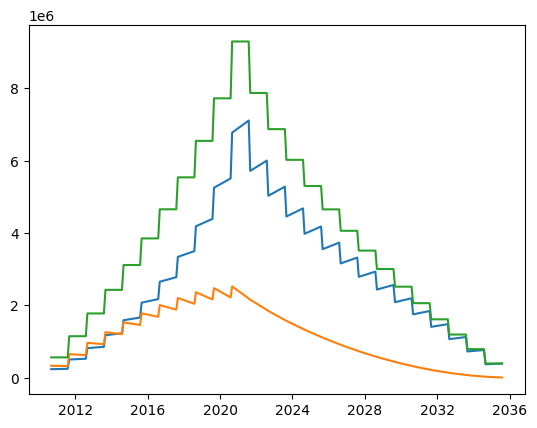

In [28]:
plt.plot(cashflows.redemptions)
plt.plot(cashflows.interests)
plt.plot(cashflows.total)

In [29]:
accrualVisitor = Visitors.AccruedAmountConstVisitor(Parsers.parseDate("2020-08-01"), Parsers.parseDate("2020-09-01"))
for inst in instruments:
    accrualVisitor.visit(inst)
accrualVisitor.getResults()

2520977.0744802905

In [30]:
class RollOverMachine:
    def __init__(self, evalStart, evalEnd, marketStore):
        self.evalStart = evalStart
        self.evalEnd = evalEnd
        self.marketStore = marketStore
        self.simInstruments = []

    def __getMarketData(self, evalDate, request):
        model = Atlas.SpotMarketDataModel(request, self.marketStore)
        return model.marketData(evalDate)

    def __getMaturingAmount(self, evalDate, instruments):
        visitor = Visitors.MaturingAmountConstVisitor(evalDate)
        for inst in instruments:
            visitor.visit(inst)
        return visitor.getResults()        
    
    def __createNewInstrument(self, startDate, endDate, paymentFrequency, notional, discountContext):
        tmpRate = Atlas.InterestRate(0.01, Atlas.Actual360(), Atlas.Compounded, Atlas.Annual)
        inst = Atlas.EqualPaymentInstrument(startDate, endDate, paymentFrequency, notional, tmpRate, discountContext2q3w4>azshjklñ)
        
        tmpIndexer = Visitors.IndexingVisitor()
        tmpIndexer.visit(inst)
        tmpRequest = tmpIndexer.getResults()
        marketData = self.__getMarketData(startDate, tmpRequest)
        parRateVisitor = Visitors.ParRateConstVisitor(marketData)
        
        parRateVisitor.visit(inst)
        parRate = parRateVisitor.getResults()['rate']
        inst.rate(parRate)
        return inst        

    def reset(self):
        self.simInstruments = []

    def simulate(self, instruments, maturity = '5Y'):
        evalDate = self.evalStart
        period = Parsers.parsePeriod(maturity)
        while evalDate <= self.evalEnd:
            maturingAmount = self.__getMaturingAmount(evalDate, instruments+self.simInstruments)
            inst = self.__createNewInstrument(evalDate, evalDate + period, Atlas.Monthly, maturingAmount, self.marketStore.curveContext("CLF"))
            self.simInstruments.append(inst)
            evalDate = evalDate + 1

In [31]:
machine = RollOverMachine(evalDate, Parsers.parseDate("2020-12-31"), store)
machine.simulate(instruments)

RuntimeError: unable to bracket root in 100 function evaluations (last bracket attempt: f[-3.10336e+24,1.1936e+24] -> [nan,1.76289e+244])

In [ ]:
import QuantLib as ql
date = ql.Date(1, 8, 2020)
date + ql.Period(1, ql.Years)

Date(1,8,2021)